#### importing the libraries

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F 

#### data directory path


In [12]:
import os

In [13]:
data_dir = r"C:\Users\admin\PycharmProjects\signatureVerification\notebook\Data"

#### Total no. of classes


In [14]:
class_name = os.listdir(data_dir)
len(class_name)

2

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms as T


#### checking the cuda availability


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:{}".format(device))
      

Device:cpu


#### Transforming the data

In [17]:
data_transform = T.Compose([
                        T.Resize((224,224)),
                        T.RandomRotation(degrees=(-10,+10)),
                        T.ToTensor(),
                        T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
                

In [18]:
data = datasets.ImageFolder(data_dir, transform=data_transform)
totalDataCount = len(data)

In [19]:
totalDataCount 

6176

In [20]:
data.classes


['Forged', 'Original']

#### splitting the data


In [21]:
training_data_count = int(0.6*totalDataCount)
validation_data_count = int(0.3*totalDataCount)
testing_data_count = totalDataCount - training_data_count - validation_data_count
training_data,validation_data,testing_data = torch.utils.data.random_split(data,(training_data_count,validation_data_count,testing_data_count))

In [22]:
training_data.dataset

Dataset ImageFolder
    Number of datapoints: 6176
    Root location: C:\Users\admin\PycharmProjects\signatureVerification\notebook\Data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [23]:
len(training_data.indices)

3705

In [24]:
len(validation_data.indices)

1852

In [25]:
len(testing_data.indices)

619

In [26]:
def show_image(image,label,get_denormalize = True):
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])

    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
    else:
        plt.imshow(image)
        plt.title(label)

def accuracy(y_pred, y_true):
    y_pred = F.softmax(y_pred,dim=1)
    top_P,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

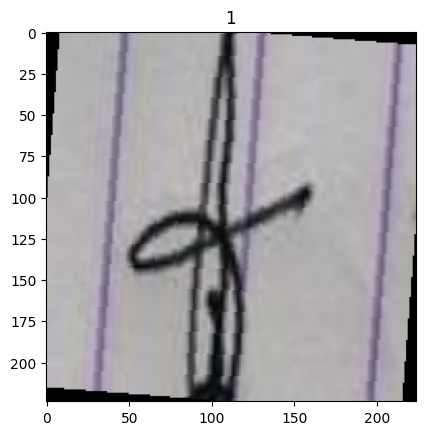

In [27]:
img, label = training_data[0]
show_image(img, label)

#### Load the transformed data

In [28]:
trainLoader = DataLoader(training_data, batch_size=32, shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainLoader)))
print("No. of total examples:{}".format(len(trainLoader.dataset)))

validationLoader = DataLoader(validation_data, batch_size=32, shuffle=True)
print("No. of batches in trainloader:{}".format(len(validationLoader)))
print("No. of total examples:{}".format(len(validationLoader.dataset)))

testingLoader = DataLoader(testing_data, batch_size=32, shuffle=False)
print("No. of batches in trainloader:{}".format(len(testingLoader)))
print("No. of total examples:{}".format(len(testingLoader.dataset)))


No. of batches in trainloader:116
No. of total examples:3705
No. of batches in trainloader:58
No. of total examples:1852
No. of batches in trainloader:20
No. of total examples:619


#### Making a Model 

In [29]:
from torchvision import models
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm


In [30]:
# Load pretrained ResNet34
model = models.resnet34(pretrained=True)

C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
# Get number of input features for the last layer
in_features = model.fc.in_features

# Replace the fully connected layer for your classification task
model.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(in_features, len(class_name))
)

# Move model to device (CPU or GPU)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [100]:
def train(model, criterion, optimizer, train_dataloader, test_dataloader):
    total_train_loss =0
    total_test_loss =0

    model.train()
    with tqdm(train_dataloader, unit='batch', leave=False) as pbar:
        pbar.set_description(f'training')
        for images, idxs in pbar:
            images =images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)
            
            output = model(images)
            loss = criterion(output, idxs)
            total_train_loss +=loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

    model.eval()
    with tqdm(test_dataloader, unit='batch', leave=False) as pbar:
        pbar.set_description(f'testing')
        for images, idxs in pbar:
            images =images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)
            
            output = model(images)
            loss = criterion(output, idxs)
            total_test_loss +=loss.item()

    train_accuracy = total_train_loss / len(training_data)
    test_accuracy = total_test_loss / len(validation_data)
    print(f'Train loss: {train_accuracy:.4f} Test loss: {train_accuracy:.4f}')


In [101]:
# How much time will the model take to train
%time
epochs=2
for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")
    train(model, criterion, optimizer, trainLoader, validationLoader)

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/2


Train loss: 0.0206 Test loss: 0.0206
Epoch 2/2


Train loss: 0.0150 Test loss: 0.0150


#### save a model


In [32]:
path =r'C:\\Users\\admin\\PycharmProjects\\signatureVerification\\notebook\\model.pt'
torch.save(model.state_dict(), path)

In [33]:
pwd

'C:\\Users\\admin\\PycharmProjects\\signatureVerification\\notebook'

#### Loading a torch model

In [34]:
import torch
import torch.nn as nn
from torchvision import models

# Define the number of output classes based on your dataset
num_classes = 2  # Update to the number of classes in your case

# Step 1: Recreate the ResNet34 architecture
model = models.resnet34(pretrained=False)  # Use pretrained=False if you're not using ImageNet weights
model.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(model.fc.in_features, num_classes)  # Change num_classes as per your dataset
)

# Step 2: Load the state_dict (model weights)
model.load_state_dict(torch.load(path))

# Step 3: Set the model to evaluation mode
model.eval()


C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Evaluate a model

In [35]:
def evaluation(model, criterion, optimizer, test_dataloader):
    total_test_loss = 0

    model.eval()
    with tqdm(test_dataloader, unit='batch', leave=False) as pbar:
        pbar.set_description(f'testing')
        for images, idxs in pbar:
            images =images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)
            
            output = model(images)
            loss = criterion(output, idxs)
            total_test_loss +=loss.item()

    test_accuracy = total_test_loss / len(validation_data)
    print(f'Test loss: {test_accuracy:.4f}')


In [106]:
evaluation(model, criterion, optimizer, testingLoader)


Test loss: 0.0059


#### Prediction for this particular model

In [36]:
label_names = data.classes
label_names

['Forged', 'Original']

In [49]:
from PIL import Image

# Load the image and preprocess it
image = Image.open(r'C:\Users\admin\PycharmProjects\signatureVerification\notebook\Data\Forged\1__JPEG_20220206_124937.jpg')

#image = Image.open(r'C:\Users\admin\PycharmProjects\signatureVerification\notebook\Data\Original\IMG_20220205_093738\1__IMG_20220205_093738.jpg')

# Check if the file exists (optional)
#import os
#if os.path.exists(image_path):
  #  print(f"Image found at: {image_path}")
#else:
 #   print(f"Image not found at: {image_path}")

# Load the image and preprocess it
#image = Image.open(image_path)

preprocess = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor()
])

image = preprocess(image)
image = image[:3]

# convert the image to a pyTorch tensor and send it to the device
image = image.unsqueeze(0).to(device)

# make the prediction
with torch.no_grad():
    logits = model(image)
    probs = torch.softmax(logits, dim=1)
    prediction_label = torch.argmax(probs, dim=1)

# print the prediction
print(f"Predicted label: {prediction_label.item()}")

# map the predicted label to the corresponding class name
predicted_class_name = label_names[prediction_label.item()]

#print the predicted class name
print(f"Predicted class name: {predicted_class_name}")

Predicted label: 0
Predicted class name: Forged
